<a href="https://colab.research.google.com/github/carlaprv/sin5007-reconhecimento-de-padroes/blob/master/06_k_fold_cross_validation_%2B_naive_Bayes_v03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes
-------------------------------------------------------------------------------------------------------------

# Bibliotecas Necessárias

In [0]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns # visualize
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from numpy import mean

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Funções Auxiliares

describe_dataset() : realiza o cálculo das proporções de classes do dataset original

In [0]:
def describe_dataset(X, y, k):
    # get dataset rows: instances , columns: features
    rows, columns = X.shape
    # get proportion from target
    (unique, counts) = np.unique(y, return_counts=True) 
    # calculate proportion
    prop_neg = int(counts[0]/rows*100)
    prop_pos = int(counts[1]/rows*100)

    print("k = {}, Dataset: {} positivas, {} negativas ({}% x {}%)".format(k, counts[1], counts[0], prop_pos, prop_neg))

get_classes_from_index() : realiza o cálculo das proporções de classes dos folds criados

In [0]:
def get_classes_from_index(y, skf):
    _, y_idx, y_inv = np.unique(y, return_index=True, return_inverse=True)
    y_counts = np.bincount(y_inv)
    _, class_perm = np.unique(y_idx, return_inverse=True)
    y_encoded = class_perm[y_inv]
    y_order = np.sort(y_encoded)
    n_classes = len(y_idx)
    allocation = np.asarray(
            [np.bincount(y_order[i::skf.n_splits], minlength=n_classes)
             for i in range(skf.n_splits)])

    for idx, f in enumerate(allocation):
        count_neg = int(f[0])
        count_pos = int(f[1])
        total = count_neg+count_pos
        prop_temp_neg = int(count_neg/total*100)
        prop_temp_pos = int(count_pos/total*100)
        print("Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {}% x {}%".format(idx, count_pos, count_neg, total, prop_temp_pos, prop_temp_neg))

# Função que aplica o Naive Bayes

In [0]:
def stratified_k_fold(X, y, list_c, k, name):
    """
    Parameters
    ----------    
       X : array-like, shape (n_samples, n_features)
           Training data, where n_samples is the number of samples
           and n_features is the number of features.
       y : array-like, of length n_samples
           The target variable for supervised learning problems.
       k : int
           Determines the number of folds.
    name : method selection (string)

    """

    ### Estratifica o dataset em k folds
    skf = StratifiedKFold(n_splits=k)
    describe_dataset(X, y, k)
    get_classes_from_index(y, skf)
    
    
    ### Lista para armazenar os resultados de cada valor de c
    ### Armazena um array bidimensional, onde terá o valor do c e uma lista dos resultados de c
    result = []
    reports_g = []
    
    
    ### Executa o treino e teste para cada valor do parametro c
    for c in list_c:
        print("c =  {}" .format(c))

        ### create naive bayes classifier
        clf = GaussianNB(var_smoothing = c)
        
        
        ### Array para guardar os resultados dos testes para o parametro c
        """
        Coluna 0 : Armazena o valor de c
        Coluna 1 : Armazena o resultado 
        """
        result_c = []

                
        ### resultado do fold-k
        result_k = []
        ### Executa o treino e teste para k folds
        fold_k = 1
        for train_index, test_index in skf.split(X, y):
            
            print("fold_k: {}" .format(fold_k))
            print("\nTRAIN: {}  TEST: {}".format(len(train_index), len(test_index)))
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            ### train classifier
            clf.fit(X_train, y_train)
            
            ### calculate metrics
            y_predicted = clf.predict(X_test)
            report_dict = metrics.classification_report(y_test, y_predicted, output_dict=True)
            report_str = metrics.classification_report(y_test, y_predicted)
                
            ### Armazena o resultado do test do fold-k          
            result_k.append(report_dict)
            print(report_str)
            
            fold_k = fold_k + 1
            

        ### Guarda os resultados dos k fold do parametro c
        reports = pd.DataFrame(pd.DataFrame(result_k)['1.0'].to_list())
        
        accuracy_reports = pd.DataFrame(pd.DataFrame(result_k)['accuracy'])
        reports['accuracy'] = accuracy_reports
        print(reports)
        reports_c = reports
        reports_c['Param(c)'] = c
        reports_c['method'] = str(name)
        reports_g.append(reports_c)
                
        ### Guarda o resultado da execução para o parâmetro c
        result_c = [c, reports]
        result.append(result_c)
        
    
    ### Retorna a lista com todos os resultado para cada c
    return result , reports_g
       

# Função para calcular a média das medidas

In [0]:
# Calcula a média das medidas de cada c
def calcula_media(lista_result):
    
    mean_c = []
    for result in lista_result:
        
        c = result[0]
        result_c = result[1]
        
        # Calcula a média das medidas do parametro c
        precision_mean = result_c['precision'].mean()
        recall_mean = result_c['recall'].mean()
        f1_score_mean = result_c['f1-score'].mean()
        support_mean = result_c['support'].mean()
        accuracy_mean = result_c['accuracy'].mean()
        
        # Armazena a média das medidas do parametro c
        mean_c.append([c, precision_mean, recall_mean, f1_score_mean, support_mean, accuracy_mean])
    
    name_columns = ['c', 'precision_mean', 'recall_mean', 'f1_score_mean', 'support_mean', 'accuracy_mean']
    mean_c = pd.DataFrame(mean_c, columns=name_columns)
    return mean_c

##### Parâmetros de execução do Naive Bayes
list_c : valores do parâmetro de ajuste de probabilidade 

k_folds : número de folds para a estratificação do dataset

In [0]:
list_c = [0.001, 0.10, 0.25, 0.50, 0.75, 1]
k_folds = 10

# Execução base: Todas as características

In [0]:
df = pd.read_csv('results/dataset-normalizado.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
result_all_features , result_all_features_g = stratified_k_fold(X, y, list_c, k=k_folds, name='All Features')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)
Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%
c =  0.001
fold_k: 1

TRAIN: 584  TEST: 65
              precision    recall  f1-score   support

         0.0       0.80      0.13      0.22        31
         1.0       0.55      0.97      0.70        34

    accuracy                           0.57        65
   macro avg       0.68      0.55      0.46        65
weighted avg       0.67      0.57      0.47    

Resultado dos k-fold para cada valor de c

In [0]:
result_all_features

[[0.001,
     precision    recall  f1-score  support  accuracy  Param(c)        method
  0   0.550000  0.970588  0.702128       34  0.569231     0.001  All Features
  1   0.625000  0.857143  0.722892       35  0.646154     0.001  All Features
  2   0.763158  0.828571  0.794521       35  0.769231     0.001  All Features
  3   0.666667  0.800000  0.727273       35  0.676923     0.001  All Features
  4   0.717949  0.800000  0.756757       35  0.723077     0.001  All Features
  5   0.775000  0.885714  0.826667       35  0.800000     0.001  All Features
  6   0.846154  0.942857  0.891892       35  0.876923     0.001  All Features
  7   0.685714  0.685714  0.685714       35  0.661538     0.001  All Features
  8   0.888889  0.457143  0.603774       35  0.676923     0.001  All Features
  9   0.730769  0.558824  0.633333       34  0.656250     0.001  All Features],
 [0.1,
     precision    recall  f1-score  support  accuracy  Param(c)        method
  0   0.559322  0.970588  0.709677       34  0

Calcula a média das medidas de cada parâmetro c

In [0]:
result_all_features_mean = calcula_media(result_all_features)
result_all_features_mean

,c,precision_mean,recall_mean,f1_score_mean,support_mean,accuracy_mean
0,0.001,0.724930,0.778655,0.734495,34.8,0.705625
1,0.100,0.733687,0.781597,0.739795,34.8,0.714880
2,0.250,0.724827,0.793025,0.739326,34.8,0.711779
3,0.500,0.711727,0.807395,0.740652,34.8,0.705625
4,0.750,0.713436,0.824538,0.750086,34.8,0.710240
5,1.000,0.704294,0.838824,0.752750,34.8,0.705625


Obtém as medidas da maior média de acurácia

In [0]:
best_accuracy_all_features = pd.Series(result_all_features_mean.iloc[result_all_features_mean['accuracy_mean'].idxmax()], 
                          name='All Features')
best_all_features = pd.DataFrame(best_accuracy_all_features)
best_all_features

,All Features
c,0.100000
precision_mean,0.733687
recall_mean,0.781597
f1_score_mean,0.739795
support_mean,34.800000
accuracy_mean,0.714880


# Execução Base: PCA

In [0]:
df = pd.read_csv('results/dataset-pca.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
result_pca , result_pca_g = stratified_k_fold(X, y, list_c, k=k_folds, name='PCA')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)
Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%
c =  0.001
fold_k: 1

TRAIN: 584  TEST: 65
              precision    recall  f1-score   support

         0.0       1.00      0.16      0.28        31
         1.0       0.57      1.00      0.72        34

    accuracy                           0.60        65
   macro avg       0.78      0.58      0.50        65
weighted avg       0.77      0.60      0.51    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resultado dos k-fold para cada valor de c

In [0]:
result_pca

[[0.001,    precision    recall  f1-score  support  accuracy  Param(c) method
  0   0.566667  1.000000  0.723404       34  0.600000     0.001    PCA
  1   0.615385  0.914286  0.735632       35  0.646154     0.001    PCA
  2   0.810811  0.857143  0.833333       35  0.815385     0.001    PCA
  3   0.617021  0.828571  0.707317       35  0.630769     0.001    PCA
  4   0.666667  0.685714  0.676056       35  0.646154     0.001    PCA
  5   0.823529  0.800000  0.811594       35  0.800000     0.001    PCA
  6   0.828571  0.828571  0.828571       35  0.815385     0.001    PCA
  7   0.692308  0.514286  0.590164       35  0.615385     0.001    PCA
  8   0.928571  0.371429  0.530612       35  0.646154     0.001    PCA
  9   0.736842  0.411765  0.528302       34  0.609375     0.001    PCA],
 [0.1,    precision    recall  f1-score  support  accuracy  Param(c) method
  0   0.539683  1.000000  0.701031       34  0.553846       0.1    PCA
  1   0.589286  0.942857  0.725275       35  0.615385       0.1

Calcula a média das medidas de cada parâmetro c

In [0]:
result_pca_mean = calcula_media(result_pca)
result_pca_mean

,c,precision_mean,recall_mean,f1_score_mean,support_mean,accuracy_mean
0,0.001,0.728637,0.721176,0.696499,34.8,0.682476
1,0.100,0.697242,0.775714,0.713713,34.8,0.674808
2,0.250,0.686046,0.836134,0.737563,34.8,0.682548
3,0.500,0.680531,0.870504,0.749448,34.8,0.687188
4,0.750,0.668754,0.881933,0.748894,34.8,0.681010
5,1.000,0.660833,0.896303,0.751560,34.8,0.677957


Obtém o resultado da maior média de acurácia 

In [0]:
best_accuracy_pca = pd.Series(result_pca_mean.iloc[result_pca_mean['accuracy_mean'].idxmax()], 
                          name='PCA')
best_pca = pd.DataFrame(best_accuracy_pca)
best_pca

,PCA
c,0.500000
precision_mean,0.680531
recall_mean,0.870504
f1_score_mean,0.749448
support_mean,34.800000
accuracy_mean,0.687188


# Execução Base: Chi Squared (K-Best)

In [0]:
df = pd.read_csv('results/dataset-fs-chi-squared.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
result_chi , result_chi_g  = stratified_k_fold(X, y, list_c, k=k_folds, name='CHI')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)
Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%
c =  0.001
fold_k: 1

TRAIN: 584  TEST: 65
              precision    recall  f1-score   support

         0.0       0.83      0.16      0.27        31
         1.0       0.56      0.97      0.71        34

    accuracy                           0.58        65
   macro avg       0.70      0.57      0.49        65
weighted avg       0.69      0.58      0.50    

Resultado dos k-fold para cada valor de c

In [0]:
result_chi

[[0.001,    precision    recall  f1-score  support  accuracy  Param(c) method
  0   0.559322  0.970588  0.709677       34  0.584615     0.001    CHI
  1   0.647059  0.942857  0.767442       35  0.692308     0.001    CHI
  2   0.810811  0.857143  0.833333       35  0.815385     0.001    CHI
  3   0.688889  0.885714  0.775000       35  0.723077     0.001    CHI
  4   0.710526  0.771429  0.739726       35  0.707692     0.001    CHI
  5   0.842105  0.914286  0.876712       35  0.861538     0.001    CHI
  6   0.871795  0.971429  0.918919       35  0.907692     0.001    CHI
  7   0.742857  0.742857  0.742857       35  0.723077     0.001    CHI
  8   0.944444  0.485714  0.641509       35  0.707692     0.001    CHI
  9   0.750000  0.617647  0.677419       34  0.687500     0.001    CHI],
 [0.1,    precision    recall  f1-score  support  accuracy  Param(c) method
  0   0.540984  0.970588  0.694737       34  0.553846       0.1    CHI
  1   0.615385  0.914286  0.735632       35  0.646154       0.1

Calcula a média das medidas de cada parâmetro c

In [0]:
result_chi_mean = calcula_media(result_chi)
result_chi_mean

,c,precision_mean,recall_mean,f1_score_mean,support_mean,accuracy_mean
0,0.001,0.756781,0.815966,0.768260,34.8,0.741058
1,0.100,0.757260,0.795966,0.755794,34.8,0.728750
2,0.250,0.749808,0.795882,0.752734,34.8,0.722548
3,0.500,0.746037,0.818824,0.760984,34.8,0.727187
4,0.750,0.736571,0.824538,0.758620,34.8,0.722548
5,1.000,0.725369,0.827395,0.755240,34.8,0.716394


Obtém o resultado da maior média de acurácia

In [0]:
best_accuracy_chi = pd.Series(result_chi_mean.iloc[result_chi_mean['accuracy_mean'].idxmax()], 
                          name='Chi Squared')
best_chi = pd.DataFrame(best_accuracy_chi)
best_chi

,Chi Squared
c,0.001000
precision_mean,0.756781
recall_mean,0.815966
f1_score_mean,0.768260
support_mean,34.800000
accuracy_mean,0.741058


# Execução Base: recursive-feature

In [0]:
df = pd.read_csv('results/dataset-fs-recursive-feature.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
result_recursive , result_recursive_g  = stratified_k_fold(X, y, list_c, k=k_folds, name='Recursive')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)
Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%
c =  0.001
fold_k: 1

TRAIN: 584  TEST: 65
              precision    recall  f1-score   support

         0.0       1.00      0.13      0.23        31
         1.0       0.56      1.00      0.72        34

    accuracy                           0.58        65
   macro avg       0.78      0.56      0.47        65
weighted avg       0.77      0.58      0.48    

Resultado dos k-fold para cada valor de c 

In [0]:
result_recursive

[[0.001,
     precision    recall  f1-score  support  accuracy  Param(c)     method
  0   0.557377  1.000000  0.715789       34  0.584615     0.001  Recursive
  1   0.640000  0.914286  0.752941       35  0.676923     0.001  Recursive
  2   0.761905  0.914286  0.831169       35  0.800000     0.001  Recursive
  3   0.636364  0.800000  0.708861       35  0.646154     0.001  Recursive
  4   0.727273  0.914286  0.810127       35  0.769231     0.001  Recursive
  5   0.761905  0.914286  0.831169       35  0.800000     0.001  Recursive
  6   0.850000  0.971429  0.906667       35  0.892308     0.001  Recursive
  7   0.644444  0.828571  0.725000       35  0.661538     0.001  Recursive
  8   0.857143  0.685714  0.761905       35  0.769231     0.001  Recursive
  9   0.750000  0.705882  0.727273       34  0.718750     0.001  Recursive],
 [0.1,    precision    recall  f1-score  support  accuracy  Param(c)     method
  0   0.532258  0.970588  0.687500       34  0.538462       0.1  Recursive
  1   0.6

Calcula a média das medidas de cada parâmetro c

In [0]:
result_recursive_mean = calcula_media(result_recursive)
result_recursive_mean

,c,precision_mean,recall_mean,f1_score_mean,support_mean,accuracy_mean
0,0.001,0.718641,0.864874,0.777090,34.8,0.731875
1,0.100,0.716993,0.879076,0.778003,34.8,0.728774
2,0.250,0.706082,0.896218,0.778610,34.8,0.724183
3,0.500,0.690841,0.913445,0.777125,34.8,0.716466
4,0.750,0.681550,0.919160,0.774406,34.8,0.710288
5,1.000,0.670595,0.927731,0.771593,34.8,0.702572


Obtém o resultado da maior média de acurácia

In [0]:
best_accuracy_recursive = pd.Series(result_recursive_mean.iloc[result_recursive_mean['accuracy_mean'].idxmax()], 
                          name='Recursive Feature')
best_recursive = pd.DataFrame(best_accuracy_recursive)
best_recursive

,Recursive Feature
c,0.001000
precision_mean,0.718641
recall_mean,0.864874
f1_score_mean,0.777090
support_mean,34.800000
accuracy_mean,0.731875


# Junta todos os resultados

In [0]:
result = pd.concat([best_all_features, best_pca, best_chi, best_recursive], axis=1)

print("Média das métricas geradas pelo processamento de cada dataset")
result.transpose()

Média das métricas geradas pelo processamento de cada dataset


,c,precision_mean,recall_mean,f1_score_mean,support_mean,accuracy_mean
All Features,0.100,0.733687,0.781597,0.739795,34.8,0.714880
PCA,0.500,0.680531,0.870504,0.749448,34.8,0.687188
Chi Squared,0.001,0.756781,0.815966,0.768260,34.8,0.741058
Recursive Feature,0.001,0.718641,0.864874,0.777090,34.8,0.731875


# Gerar Graficos

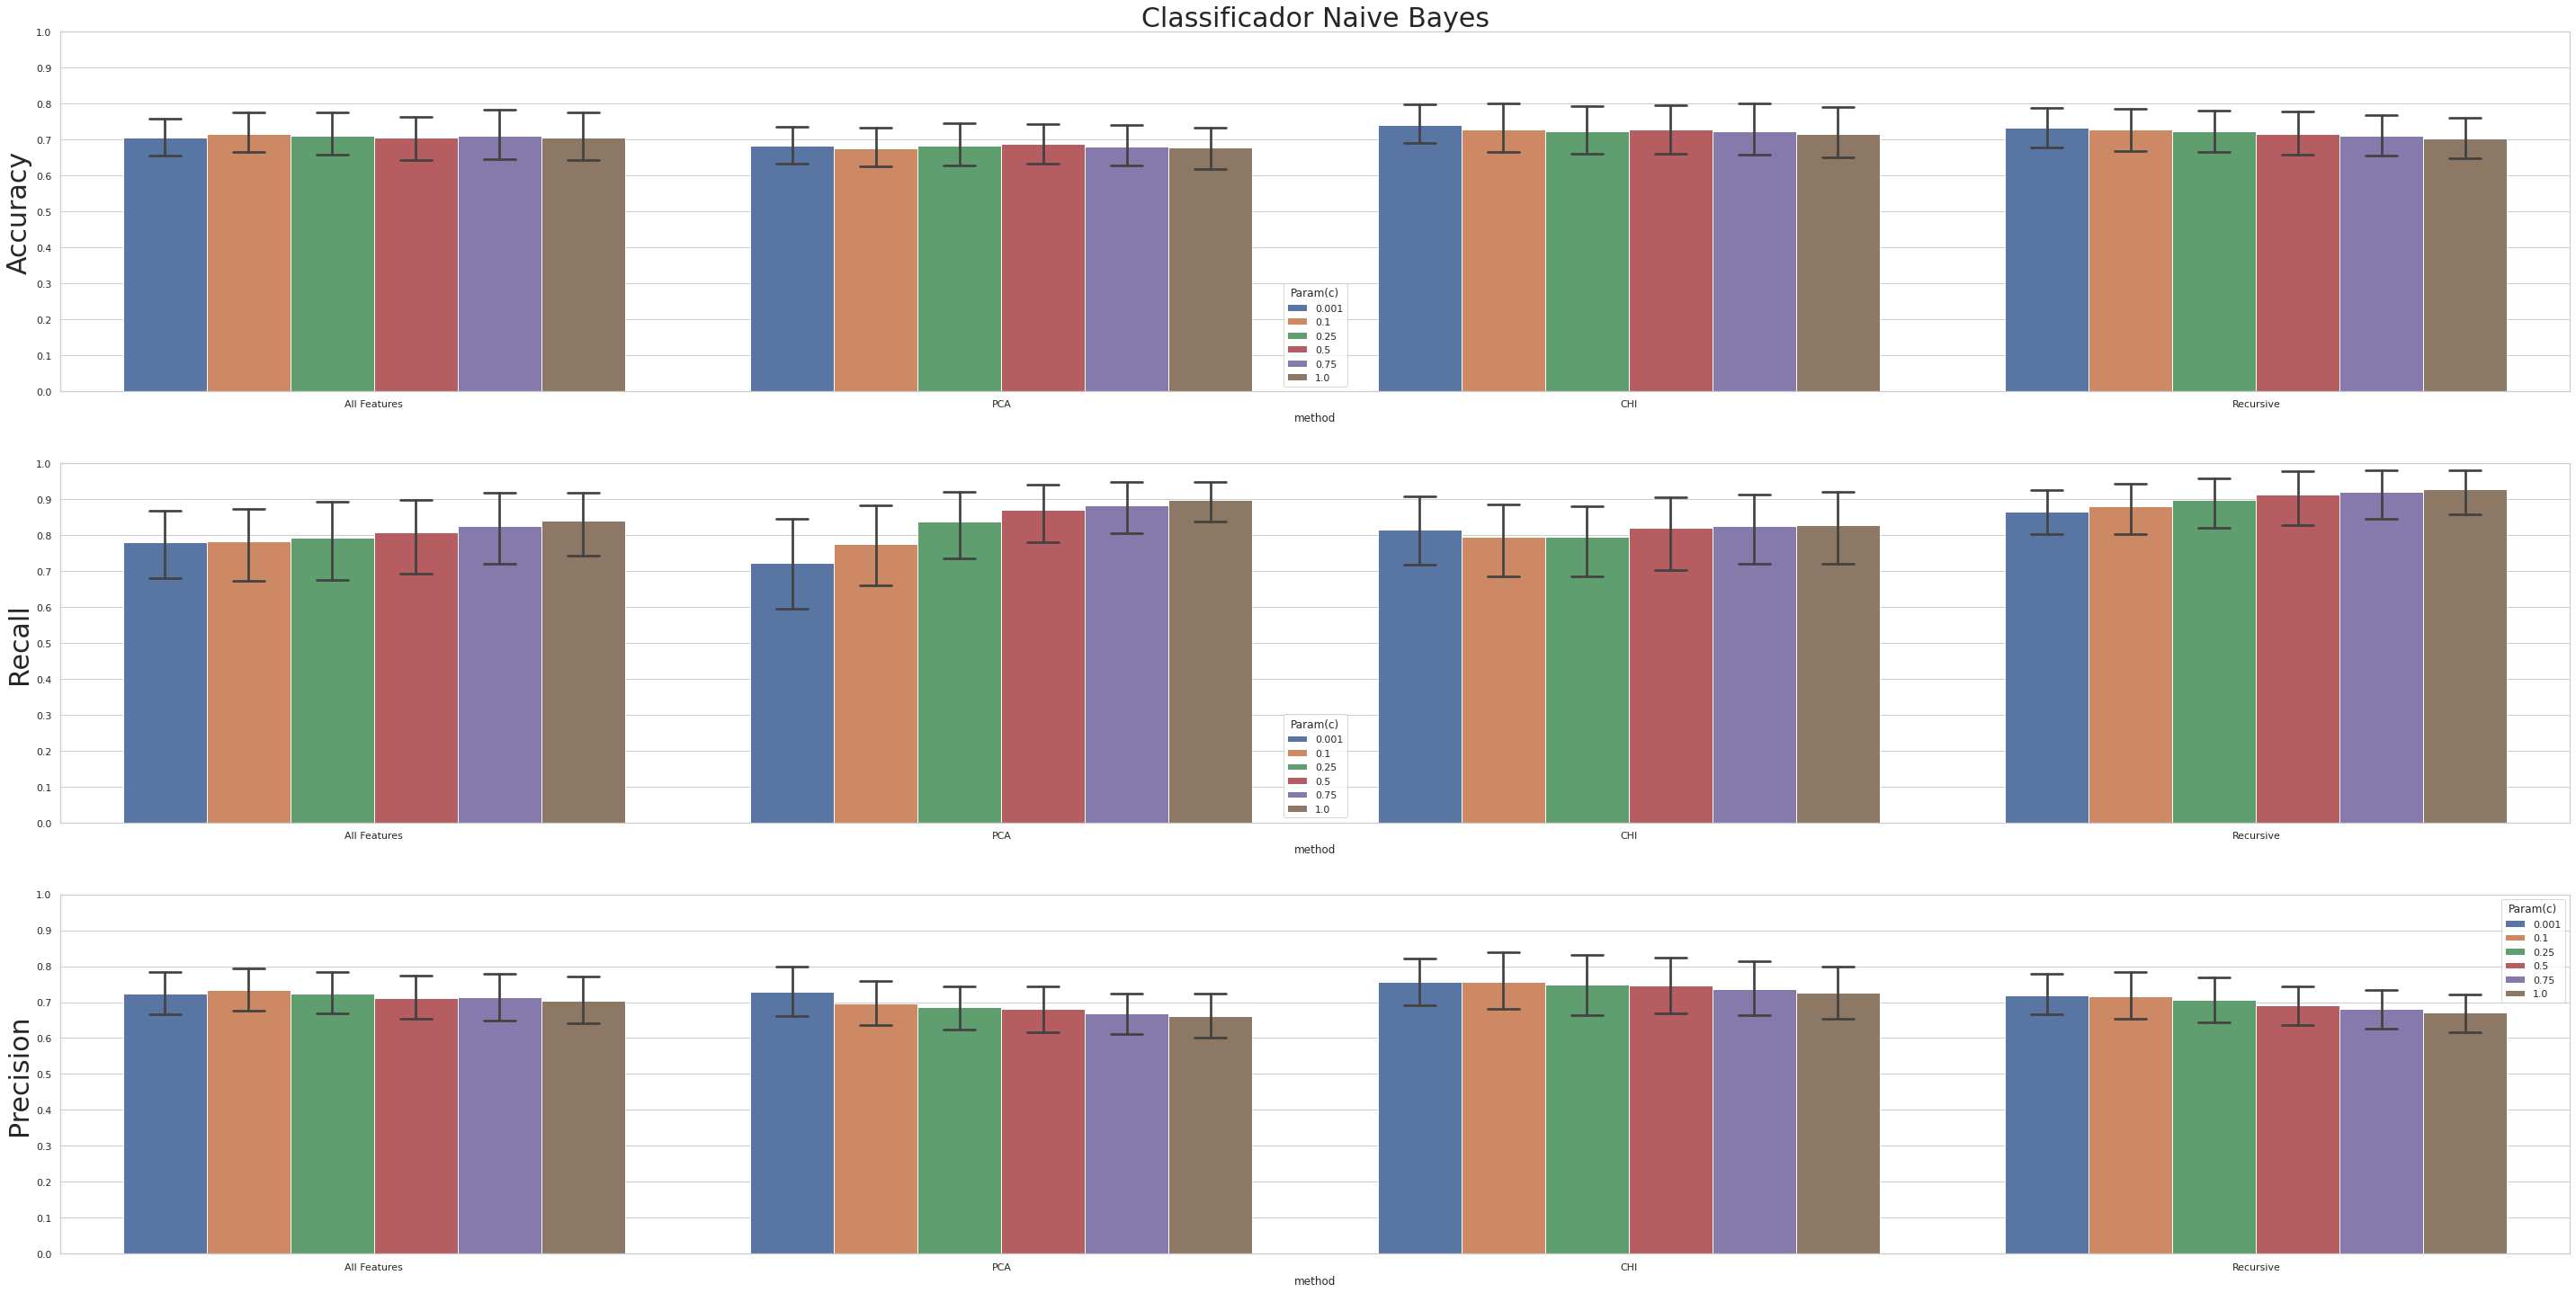

In [0]:
frames = result_all_features_g +  result_pca_g + result_chi_g + result_recursive_g

tips = pd.concat(frames)

sns.set(style="whitegrid")

fig, ax = plt.subplots(3,1,figsize=[50,25])

g = sns.barplot(ax=ax[0], x="method", y="accuracy", hue="Param(c)", data=tips,capsize=.05)
g.set(ylim=(0,1),yticks=np.arange(0,1.1,0.1).tolist())
g.set_ylabel("Accuracy",fontsize=30)
g.set_title('Classificador Naive Bayes',fontsize=30)
g = sns.barplot(ax=ax[1], x="method", y="recall", hue="Param(c)", data=tips,capsize=.05);
g.set(ylim=(0,1),yticks=np.arange(0,1.1,0.1).tolist())
g.set_ylabel("Recall",fontsize=30)
g = sns.barplot(ax=ax[2], x="method", y="precision", hue="Param(c)", data=tips,capsize=.05);
g.set(ylim=(0,1),yticks=np.arange(0,1.1,0.1).tolist())
g.set_ylabel("Precision",fontsize=30)
plt.close(2)
